#Liel Dadush - Machine Learning Project - Cancer Patient Survival

In [1]:
from scipy import stats as stat
import statistics
from statistics import mode
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import missingno as mno
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
%matplotlib inline


In [2]:
# from google.colab import files
# file = files.upload()

path = "/content/drive/MyDrive/Datasets/Cancer Patient Survival.csv"
df = pd.read_csv(path)

# df.head(5)



#Read the file into a pandas data frame

In [3]:
#Split the data
X = df.drop ('Status', axis=1)
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2)


#Check for missing values

In [4]:
print(df.isnull().sum())


Status                    4
Age                       0
Regional Node Examined    2
Reginol Node Positive     1
Survival Months           3
Tumor Size                3
dtype: int64



#Impute Missing Values Using Two Different Techniques and Save the Processed Datasets

In [5]:
# First Technique - Impute with Mean, Median, or Mode

df['Tumor Size'] = df['Tumor Size'].fillna(df['Tumor Size'].mean())

df['Survival Months'] = df['Survival Months'].fillna(df['Survival Months'].median())

df['Status'] = df['Status'].fillna(df['Status'].mode()[0])

# Check for missing values after Step 1
print("\nMissing Values After Mean/Median/Mode Imputation:")
print(df.isnull().sum())

# Second Technique - Drop Rows with Remaining Missing Values

df = df.dropna()

# Final check for missing values
print("\nFinal Missing Values Check (After Dropping Rows):")
print(df.isnull().sum())


Missing Values After Mean/Median/Mode Imputation:
Status                    0
Age                       0
Regional Node Examined    2
Reginol Node Positive     1
Survival Months           0
Tumor Size                0
dtype: int64

Final Missing Values Check (After Dropping Rows):
Status                    0
Age                       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Tumor Size                0
dtype: int64


#Preprocessing the data

In [6]:
# Normalize numerical columns using MinMaxScaler
scaler = MinMaxScaler()
numerical_columns = ['Tumor Size', 'Survival Months', 'Reginol Node Positive', 'Regional Node Examined', 'Age']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

pd.set_option('display.width', 1000)
print("Normalized Data (First 5 rows):")
print(df.head())


Normalized Data (First 5 rows):
  Status       Age  Regional Node Examined  Reginol Node Positive  Survival Months  Tumor Size
0  Alive  0.974359                0.383333               0.000000         0.556604    0.021583
1  Alive  0.512821                0.216667               0.088889         0.575472    0.244604
2  Alive  0.717949                0.216667               0.133333         0.698113    0.446043
3  Alive  0.717949                0.016667               0.000000         0.783019    0.122302
4  Alive  0.435897                0.033333               0.000000         0.462264    0.287770


<ipython-input-6-7e97b5f40cf7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


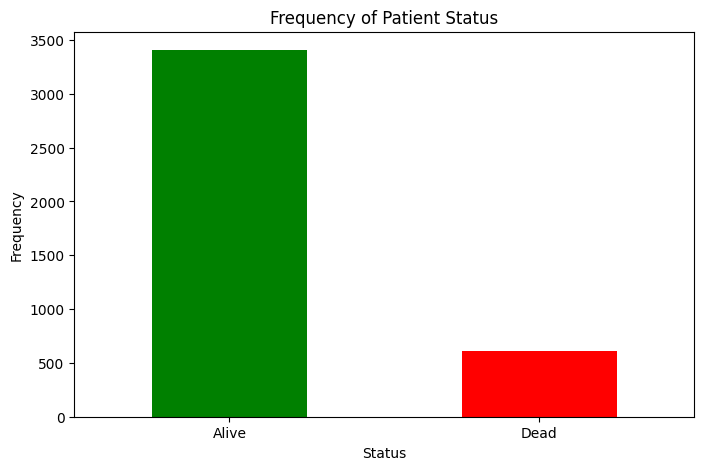

In [7]:
# Count the frequency of each category in 'Status'
status_counts = df['Status'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 5))
status_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Frequency of Patient Status')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


#Checking and imputing missing values



In [8]:
def plot_class_distribution(y, title):
    from collections import Counter
    counts = Counter(y)

    # Convert counts keys to integers and ensure labels are strings
    labels = ['Alive', 'Dead'] if set(counts.keys()) == {0, 1} else list(map(str, counts.keys()))
    values = list(counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=['green', 'red'])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



In [9]:
# Check for missing values in X_train
nan_count_X_train = pd.DataFrame(X_train).isnull().sum().sum()
print(f"Number of NaN values in X_train: {nan_count_X_train}")

# Check for missing values in y_train
nan_count_y_train = y_train.isnull().sum()
print(f"Number of NaN values in y_train: {nan_count_y_train}")

print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")



Number of NaN values in X_train: 8
Number of NaN values in y_train: 4
Length of X_train: 3219
Length of y_train: 3219


In [10]:
# Fill missing values in X_train with column means
imputer_X = SimpleImputer(strategy='mean')
X_train = imputer_X.fit_transform(X_train)

# Fill missing values in y_train with the most frequent value
y_train.fillna(y_train.mode()[0], inplace=True)

# Confirm no missing values and lengths are consistent
print(f"Number of NaN values in X_train: {pd.DataFrame(X_train).isnull().sum().sum()}")
print(f"Number of NaN values in y_train: {y_train.isnull().sum()}")
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")

Number of NaN values in X_train: 0
Number of NaN values in y_train: 0
Length of X_train: 3219
Length of y_train: 3219


Class distribution after balancing with SMOTE:


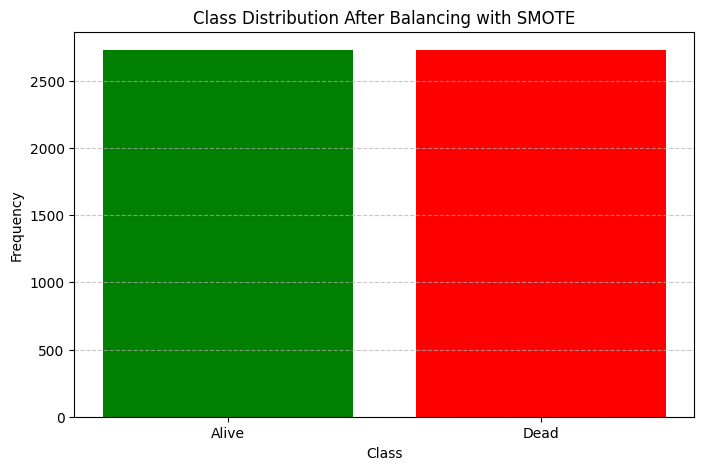

Counter({'Alive': 2729, 'Dead': 2729})


In [11]:
# Initialize SMOTE
smote = SMOTE(random_state=101)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display the class distribution after balancing
print("Class distribution after balancing with SMOTE:")
plot_class_distribution(y_train_resampled, 'Class Distribution After Balancing with SMOTE')
print(Counter(y_train_resampled))

#Balancing the dataset with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) helps address class imbalance by creating synthetic examples for the minority class. Instead of duplicating existing samples, it generates new ones by interpolating between existing minority samples and their nearest neighbors. This method ensures the dataset is more balanced, reduces the chance of overfitting, and allows the model to learn from both classes effectively. In this case, using SMOTE balanced the class distribution and provided a fairer representation of both classes in the training data.

#Train test split:

In [12]:
# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=101)


#Training models

In [13]:
# Initialize models
log_reg = LogisticRegression(random_state=101)
random_forest = RandomForestClassifier(random_state=101)
xgboost = XGBClassifier(random_state=101)


In [14]:
# Encode target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print("Unique values in y_train after encoding:", set(y_train))
print("Unique values in y_test after encoding:", set(y_test))
print("Label Encoding: 'Alive' = 0, 'Dead' = 1")


Unique values in y_train after encoding: {0, 1}
Unique values in y_test after encoding: {0, 1}
Label Encoding: 'Alive' = 0, 'Dead' = 1


In [15]:
# Train models
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgboost.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=101, ...)

In [16]:
# Make predictions
y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
y_pred_xgb = xgboost.predict(X_test)


In [17]:
# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"\nEvaluation for {model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")



Evaluation for Logistic Regression:
Accuracy: 0.7619047619047619
Confusion Matrix:
 [[427 129]
 [131 405]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77       556
           1       0.76      0.76      0.76       536

    accuracy                           0.76      1092
   macro avg       0.76      0.76      0.76      1092
weighted avg       0.76      0.76      0.76      1092


Evaluation for Random Forest:
Accuracy: 0.9184981684981685
Confusion Matrix:
 [[511  45]
 [ 44 492]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       556
           1       0.92      0.92      0.92       536

    accuracy                           0.92      1092
   macro avg       0.92      0.92      0.92      1092
weighted avg       0.92      0.92      0.92      1092


Evaluation for XGBoost:
Accuracy: 0.9285714285714286
Confusion Matrix:
 [[521  35]
 [ 4

In [18]:
# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [19]:
# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}


In [20]:
# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(
    estimator=xgboost,
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)


In [21]:
# Fit Random Forest GridSearch
print("Tuning Random Forest...")
rf_grid_search.fit(X_train, y_train)

# Fit XGBoost GridSearch
print("Tuning XGBoost...")
xgb_grid_search.fit(X_train, y_train)


Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Tuning XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=101, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [22]:
# Best parameters for Random Forest
print("\nBest Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best Accuracy for Random Forest:", rf_grid_search.best_score_)

# Best parameters for XGBoost
print("\nBest Parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best Accuracy for XGBoost:", xgb_grid_search.best_score_)



Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy for Random Forest: 0.9152552680071612

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy for XGBoost: 0.9214405728949597


For **Random Forest**, the selected hyperparameters are:

- max_depth: Controls how deep the trees can grow.
- min_samples_leaf: Ensures a minimum number of samples in each leaf to avoid overfitting.
- min_samples_split: Specifies the minimum samples required to split a node.
- n_estimators: Sets the number of trees in the forest.

For **XGBoost**, the hyperparameters are:

- learning_rate: Determines the size of the steps during optimization.
- max_depth: Limits tree depth to control complexity.
- n_estimators: Defines the number of boosting iterations.
- subsample: Specifies the fraction of samples used in each boosting round.

These values were chosen from ranges that balance accuracy and training time, based on commonly used configurations.

In [23]:
# Get predictions for train and test sets
train_pred_log_reg = log_reg.predict(X_train)
test_pred_log_reg = log_reg.predict(X_test)

train_pred_rf = random_forest.predict(X_train)
test_pred_rf = random_forest.predict(X_test)

train_pred_xgb = xgboost.predict(X_train)
test_pred_xgb = xgboost.predict(X_test)

print("Logistic Regression:")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_log_reg):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_log_reg):.4f}\n")

print("Random Forest:")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_rf):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_rf):.4f}\n")

print("XGBoost:")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred_xgb):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_xgb):.4f}")


Logistic Regression:
Train Accuracy: 0.7707
Test Accuracy: 0.7619

Random Forest:
Train Accuracy: 1.0000
Test Accuracy: 0.9185

XGBoost:
Train Accuracy: 0.9938
Test Accuracy: 0.9286


In [24]:
# Print detailed evaluation for each model
print("\nLogistic Regression Results:")
print(classification_report(y_test, test_pred_log_reg))

print("\nRandom Forest Results:")
print(classification_report(y_test, test_pred_rf))

print("\nXGBoost Results:")
print(classification_report(y_test, test_pred_xgb))

# Additional metric: F1 Score for XGBoost
f1_xgb = f1_score(y_test, test_pred_xgb, average="weighted")
print(f"\nXGBoost F1 Score: {f1_xgb:.4f}")


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       556
           1       0.76      0.76      0.76       536

    accuracy                           0.76      1092
   macro avg       0.76      0.76      0.76      1092
weighted avg       0.76      0.76      0.76      1092


Random Forest Results:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       556
           1       0.92      0.92      0.92       536

    accuracy                           0.92      1092
   macro avg       0.92      0.92      0.92      1092
weighted avg       0.92      0.92      0.92      1092


XGBoost Results:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       556
           1       0.93      0.92      0.93       536

    accuracy                           0.93      1092
   macro avg       0.93      0.93      0.93      1092
we

Each model is evaluated based on train and test accuracy as well as detailed metrics like precision, recall, and F1 score. A good model balances performance on both datasets. Here's what to look for:

- Logistic Regression might underperform if it’s too simple for the data.
- Random Forest could show high train accuracy but slightly lower test accuracy, which may suggest overfitting if the gap is big.
- XGBoost is often a solid choice because it balances train and test performance well. It may show strong accuracy and a high F1 score, which makes it a reliable option for this dataset.

By checking both accuracy and classification metrics, you can decide which model fits the data best without overfitting or underfitting.
